# Set path to data

In [1]:
"""
Set a path to standardized data
"""

import os

path_std = '../assets/std'
os.listdir(path_std)

['metaphor', '.DS_Store', 'summarization', 'crossword', 'question', 'dialogue']

# Common code for all tasks

In [2]:
"""
Design configurations
"""

%matplotlib inline

import os
import collections
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import Ridge

style = 'white'
offset = 10
font_scale = 2

default_model_colors = [
    '#5560A9',  # TextDavinci
    '#68A36D',  # TextBabbage
    '#FABC09',  # Davinci
    '#F19020',  # Jumbo
]

plt.rcParams["figure.figsize"] = [10, 6]
sns.set(font_scale=font_scale, style=style)
sns.color_palette(default_model_colors)

[(0.3333333333333333, 0.3764705882352941, 0.6627450980392157),
 (0.40784313725490196, 0.6392156862745098, 0.42745098039215684),
 (0.9803921568627451, 0.7372549019607844, 0.03529411764705882),
 (0.9450980392156862, 0.5647058823529412, 0.12549019607843137)]

In [126]:
"""
Generate plots
"""

def generate_lineplot(df, x, y, hue, xlabel, ylabel):
    ax = sns.lineplot(
        x=x, 
        y=y,
        hue=hue,
        data=df,
        hue_order=new_default_models,
        palette=default_model_colors,
        estimator=np.mean,
        errorbar='se',
        linewidth=3)

    leg = ax.legend(ncol=2, loc='upper center', frameon=False)
    for leg_line in leg.legendHandles:
        leg_line.set_linewidth(3)

    ax.set_xlabel(xlabel, fontsize=30)
    ax.set_ylabel(ylabel, fontsize=30)
    ax.set_xticks([])

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

    plt.tight_layout()
    plt.show()
    
    
def generate_barplot(
    model_to_mean, model_to_sem,
    labels, models, model_colors,
    xlabel, ylabel
):
    barWidth = 0.20  # the width of the bars
    num_labels = len(labels)
    num_models = len(models)

    positions = []
    default = np.arange(len(labels))
    positions.append(default)
    for i in range(num_models):
        p = []
        for x in default:
            p.append(x + barWidth * (i + 1))
        positions.append(p)

    fig, ax = plt.subplots()
    plt.rcParams["figure.figsize"] = (10, 4)

    for i, model in enumerate(models):
        rect = ax.bar(
            positions[i], 
            model_to_mean[model], 
            barWidth, 
            label=model,
            color=model_colors[i]
        )
        
        if model in model_to_sem:
            plt.errorbar(positions[i], model_to_mean[model], yerr=model_to_sem[model], color="gray", linestyle='')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_xlabel(xlabel, fontsize=25)
    ax.set_ylabel(ylabel, fontsize=25)
    ax.set_xticks([r + barWidth * (num_models / 2) - (barWidth / 2) for r in range(len(labels))], labels)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)
    
    leg = ax.legend(ncol=4, columnspacing=1, bbox_to_anchor=(0, 1.1), loc='upper left', 
                    frameon=False, prop={'size': 15})

    plt.subplots_adjust(top=0.9, bottom=0.2)

In [59]:
"""
Generate tables (with formatting for LaTeX)
"""

def print_latex(models, metrics, scales, _df, latex=True):
    df = _df[['model'] + metrics]
    
    df_mean = df.groupby(by='model').mean()
    df_sem = df.groupby(by='model').sem()
    
    results = collections.defaultdict(dict)
    for metric, scale in zip(metrics, scales):
        for model in models:
            mean = df_mean[metric].loc[model]
            sem = df_sem[metric].loc[model]
            
            if scale == 100:
                if latex:
                    result = f'{mean * scale:.0f}' + ' \\sem{' + f'{sem * scale:.1f}' + '}'
                else:
                    result = f'{mean * scale:.0f} ± {sem * scale:.1f}'
                
            elif scale == 1:
                if latex:
                    result = f'{mean:.2f}' + ' \\sem{' + f'{sem:.2f}' + '}'
                else:
                    result = f'{mean:.2f} ± {sem:.2f}'
            else:
                if latex:
                    result = f'{mean * scale:.2f}' + ' \\sem{' + f'{sem * scale:.2f}' + '}'
                else:
                    result = f'{mean * scale:.2f} ± {sem * scale:.2f}'
                    
            results[model][metric] = result

    if latex:
        print('\t\t & ' + '\t & '.join(metrics))
    else:
        print(' ' * 15 + ''.join([f'{metric:20}' for metric in metrics]))
        
    for model in models:
        result = results[model]
        if latex:
            print(model + '\t & ' + '\t & '.join([result[metric] for metric in metrics]) + ' \\\\')
        else:
            print(f'{model:15}' + ''.join([f'{result[metric]:20}' for metric in metrics]))

In [5]:
"""
Read standardized data
"""

def read_data(task):
    path_asset = os.path.join(path_std, task)
    
    data = dict()
    for data_type in ['event_blocks', 'survey_responses', 'accuracies']:
        path = os.path.join(path_asset, data_type + '.csv')
        
        if os.path.exists(path):
            df = pd.read_csv(path)
            for model_name, new_model_name in zip(default_models, new_default_models):
                df = df.replace(model_name, new_model_name)
            data[data_type] = df
        else:
            data[data_type] = None
    return data

In [6]:
"""
Set a naming scheme for models (if necessary)
"""

# How models are named in standardized data
default_models = ['InstructDavinci', 'InstructBabbage', 'Davinci', 'Jumbo']

# How you want them to appear in tables and plots
new_default_models = ['TextDavinci', 'TextBabbage', 'Davinci', 'Jumbo']

# Perform analysis per task

1. [Social dialogue](#social_dialogue)
1. [Question answering](#question_answering)
1. [Crossword puzzles](#crossword_puzzles)
1. [Text summarization](#text_summarization)
1. [Metaphor generation](#metaphor_generation)

<a id='social_dialogue'></a>

## 1. Social dialogue

In [39]:
data = read_data('dialogue')

In [40]:
df_survey = data['survey_responses']
df_survey = df_survey.rename(columns={
    "preference": "inclination",  # "Which responses made you NOT want to talk with the chatbot again?" (turn-level; binary; reversed scores for the negated question)
    "quality": "reuse"  # "Would you want to talk to this chatbot again?" (dialogue-level; 5-point Likert scale)
})
df_survey.head()

,session_id,worker_id,turn_id,model,prompt,interestingness,boringness,inclination,fluency,sensibility,specificity,humanness,reuse
0,4c208762-1acf-4b05-b068-3e6a40c4d106,ad27557f-55c8-4c38-9be7-9921a0f1286e,-1,Jumbo,I was very happy about a time when i saw an el...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
1,4c208762-1acf-4b05-b068-3e6a40c4d106,ad27557f-55c8-4c38-9be7-9921a0f1286e,1,Jumbo,I was very happy about a time when i saw an el...,1.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN
2,4c208762-1acf-4b05-b068-3e6a40c4d106,ad27557f-55c8-4c38-9be7-9921a0f1286e,2,Jumbo,I was very happy about a time when i saw an el...,1.0,0.0,1.0,0.0,0.0,1.0,0.0,NaN
3,4c208762-1acf-4b05-b068-3e6a40c4d106,ad27557f-55c8-4c38-9be7-9921a0f1286e,3,Jumbo,I was very happy about a time when i saw an el...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN
4,4c208762-1acf-4b05-b068-3e6a40c4d106,ad27557f-55c8-4c38-9be7-9921a0f1286e,4,Jumbo,I was very happy about a time when i saw an el...,0.0,0.0,1.0,1.0,1.0,1.0,0.0,NaN


In [41]:
df_sessions = df_survey.query('turn_id == -1') # turn_id of -1 is used to keep the overall quality score of each session
df_sessions = df_sessions[['model', 'reuse']]
df_sessions.head()

,model,reuse
0,Jumbo,1.0
12,TextDavinci,4.0
31,Jumbo,4.0
42,Davinci,5.0
56,Davinci,5.0


In [42]:
metrics = ['reuse']
scales = [1]
print_latex(new_default_models, metrics, scales, df_sessions, latex=False)

               reuse               
TextDavinci    4.09 ± 0.14         
TextBabbage    3.35 ± 0.16         
Davinci        3.80 ± 0.17         
Jumbo          3.21 ± 0.20         


In [43]:
df_turns = df_survey.query('turn_id > 0')  # turn_id > 0 is used to store various metrics for each turn
df_turns = df_turns[['model', 'fluency', 'sensibility', 'specificity', 'humanness', 'interestingness', 'inclination']]
df_turns.head()

,model,fluency,sensibility,specificity,humanness,interestingness,inclination
1,Jumbo,1.0,1.0,1.0,0.0,1.0,1.0
2,Jumbo,0.0,0.0,1.0,0.0,1.0,1.0
3,Jumbo,1.0,1.0,1.0,0.0,0.0,1.0
4,Jumbo,1.0,1.0,1.0,0.0,0.0,1.0
5,Jumbo,1.0,1.0,1.0,0.0,0.0,1.0


In [44]:
metrics = ['fluency', 'sensibility', 'specificity', 'humanness', 'interestingness', 'inclination']
scales = [100, 100, 100, 100, 100, 100]
print_latex(new_default_models, metrics, scales, df_turns, latex=False)

               fluency             sensibility         specificity         humanness           interestingness     inclination         
TextDavinci    93 ± 1.0            94 ± 1.0            83 ± 1.6            37 ± 2.0            36 ± 2.0            91 ± 1.2            
TextBabbage    90 ± 1.4            84 ± 1.7            81 ± 1.8            29 ± 2.1            30 ± 2.1            88 ± 1.5            
Davinci        92 ± 1.3            89 ± 1.4            92 ± 1.3            24 ± 2.0            27 ± 2.0            91 ± 1.3            
Jumbo          89 ± 1.3            86 ± 1.5            84 ± 1.5            24 ± 1.8            32 ± 2.0            87 ± 1.4            


<a id='question_answering'></a>

## 2. Question answering

In [71]:
data = read_data('question')

In [72]:
df_questions = data['event_blocks']
df_questions = df_questions.rename(columns={
    'user_correct': 'accuracy',
    'elapsed_time': 'time',
    'num_queries': 'queries',
})
df_questions.head()

,session_id,worker_id,order_id,model,prompt,sequence_id,question_id,question_type,question_category,question_text,...,answer_text,lm_used,user_queries,user_query_types,lm_responses,user_answer,accuracy,time,queries,num_events
0,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,0,TextDavinci,19,19,5,ctrl,Miscellany,In the phrase 'Y2K' what does 'K' stand for?,...,thousand,0,[],[],[],d,1,0.15,0,3
1,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,1,TextDavinci,19,19,14,ctrl,US foreign policy,"Within the United Nations, real power is locat...",...,the Security Council.,0,[],[],[],a,1,0.03,0,2
2,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,2,TextDavinci,19,19,10,ctrl,Global facts,The global HIV/AIDS death rate is highest for ...,...,15-49,0,[],[],[],c,1,0.02,0,2
3,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,3,TextDavinci,19,19,24,ctrl,College chemistry,Cobalt-60 is used in the radiation therapy of ...,...,Neutrons,0,[],[],[],d,0,0.01,0,2
4,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,4,TextDavinci,19,19,29,ctrl,College chemistry,The fact that the infrared absorption frequenc...,...,reduced mass,0,[],[],[],a,0,0.02,0,2


In [73]:
df_lm_provided = df_questions.query('question_type == "lm"')
df_lm_used = df_questions.query('queries > 0')

print(f'AI assistance was used for {len(df_lm_used)} out of {len(df_lm_provided)} questions ({len(df_lm_used) / len(df_lm_provided) * 100:.2f}\%)')

AI assistance was used for 1423 out of 1655 questions (85.98\%)


In [74]:
metrics = ['accuracy', 'time', 'queries']
scales = [100, 1, 1]
print_latex(new_default_models, metrics, scales, df_lm_used, latex=False)

               accuracy            time                queries             
TextDavinci    69 ± 2.2            1.36 ± 0.13         1.78 ± 0.06         
TextBabbage    52 ± 2.8            1.77 ± 0.33         2.57 ± 0.13         
Davinci        48 ± 2.7            2.09 ± 0.14         2.66 ± 0.12         
Jumbo          54 ± 2.9            1.67 ± 0.09         2.32 ± 0.11         


In [75]:
df_survey = data['survey_responses']
df_survey.head()

,session_id,worker_id,model,prompt,fluency,helpfulness,ease,helpfulness_freetext,change_freetext,adjectives
0,bef4fe951fd240ce80ebe96419ee78df,A22VGT2F28LTWC,TextDavinci,88,4,5,5,Helpful for the most part- I asked the same qu...,no,"helpful, easy, intelligent, knowledgeable"
1,42db869711b548d581fd1eabf6202919,A171S8E9IFSHH2,TextDavinci,54,5,5,4,it answered my questions so great,"Yes, I didn't need it until the last 2 questio...","smart, concise"
2,19c4644751d44088b202023adcface85,AFRJKS3Z3H4CA,TextDavinci,83,4,5,4,"It answered all my questions eventually, as fa...","No, I varied my approach when I needed to but ...","responsive, useful, helpful, knowledgable"
3,f18afd30c59b47fba70a52fac3a694d6,AZLZA0Q87TJZO,TextDavinci,49,3,2,5,A lot of the time the AI Assistant just repeat...,I tried to make my questions specific enough t...,"easy, frustrating, clueless"
4,c6a6b80875ea495ca1dde828cfccb608,A6KOTWP7N7RLU,TextDavinci,12,4,5,4,The AI was able to give me answers to several ...,"My interactions did not change by choice, but ...","Helpful, useful, competent."


In [76]:
metrics = ['ease', 'fluency', 'helpfulness']
scales = [1, 1, 1]
print_latex(new_default_models, metrics, scales, df_survey, latex=False)

               ease                fluency             helpfulness         
TextDavinci    4.53 ± 0.08         4.35 ± 0.07         4.60 ± 0.07         
TextBabbage    4.09 ± 0.12         3.84 ± 0.12         3.84 ± 0.12         
Davinci        3.73 ± 0.13         3.22 ± 0.11         3.52 ± 0.13         
Jumbo          3.87 ± 0.14         3.17 ± 0.11         3.26 ± 0.14         


In [77]:
df_questions.head()

,session_id,worker_id,order_id,model,prompt,sequence_id,question_id,question_type,question_category,question_text,...,answer_text,lm_used,user_queries,user_query_types,lm_responses,user_answer,accuracy,time,queries,num_events
0,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,0,TextDavinci,19,19,5,ctrl,Miscellany,In the phrase 'Y2K' what does 'K' stand for?,...,thousand,0,[],[],[],d,1,0.15,0,3
1,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,1,TextDavinci,19,19,14,ctrl,US foreign policy,"Within the United Nations, real power is locat...",...,the Security Council.,0,[],[],[],a,1,0.03,0,2
2,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,2,TextDavinci,19,19,10,ctrl,Global facts,The global HIV/AIDS death rate is highest for ...,...,15-49,0,[],[],[],c,1,0.02,0,2
3,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,3,TextDavinci,19,19,24,ctrl,College chemistry,Cobalt-60 is used in the radiation therapy of ...,...,Neutrons,0,[],[],[],d,0,0.01,0,2
4,000dc2393b854047a00caad996a7dce5,A2EED3HLTA96CP,4,TextDavinci,19,19,29,ctrl,College chemistry,The fact that the infrared absorption frequenc...,...,reduced mass,0,[],[],[],a,0,0.02,0,2


In [87]:
categories = ['Global facts', 'Nutrition', 'US foreign policy', 'College chemistry', 'Miscellany']
models = ['Human', 
          'TextDavinci', 'TextDavinci (auto)',
          'TextBabbage', 'TextBabbage (auto)',
          'Davinci', 'Davinci (auto)', 
          'Jumbo', 'Jumbo (auto)'
]

model_to_mean = dict()
model_to_sem = dict()

In [88]:
"""
Get human-only (ctrl) performance per category
"""
model = 'Human'
mean = []
sem = []
for category in categories:
    df_category = df_questions.query(f'question_type == "ctrl" & question_category == "{category}"')['accuracy']
    mean.append(round(df_category.mean() * 100))
    sem.append(round(df_category.sem() * 100))

model_to_mean[model] = mean
model_to_sem[model] = sem

model_to_mean, model_to_sem

({'Human': [32, 38, 58, 35, 79]}, {'Human': [3, 3, 3, 3, 2]})

In [89]:
"""
Get human-model collaborative performance per category
"""
for model in new_default_models:
    mean = []
    sem = []
    for category in categories:
        df_category = df_lm_used.query(f'model == "{model}" & question_type == "lm" & question_category == "{category}"')
        m = df_category['accuracy'].mean()
        s = df_category['accuracy'].sem()
        mean.append(round(m * 100))
        sem.append(round(s * 100))
    model_to_mean[model] = mean
    model_to_sem[model] = sem

model_to_mean, model_to_sem

({'Human': [32, 38, 58, 35, 79],
  'TextDavinci': [69, 47, 76, 70, 89],
  'TextBabbage': [44, 47, 71, 27, 75],
  'Davinci': [38, 35, 61, 32, 78],
  'Jumbo': [38, 45, 71, 47, 76]},
 {'Human': [3, 3, 3, 3, 2],
  'TextDavinci': [5, 5, 4, 5, 4],
  'TextBabbage': [6, 6, 6, 5, 6],
  'Davinci': [6, 6, 6, 5, 5],
  'Jumbo': [6, 7, 6, 6, 6]})

In [90]:
"""
Get model-only (auto) performance per category

The zero-shot, non-interactive QA systems' accuracy can be found at 
https://nlp.stanford.edu/helm/interactive_qa_mmlu/?suite=interactive_qa_mmlu&group=mmlu
"""
model_to_mean.update({      
    'TextDavinci (auto)': [50, 50, 100, 67, 71],       
    'TextBabbage (auto)': [33, 17, 17, 0, 14],
    'Davinci (auto)': [33, 33, 100, 17, 57],
    'Jumbo (auto)': [33, 33, 17, 33, 14],
})
model_to_mean

{'Human': [32, 38, 58, 35, 79],
 'TextDavinci': [69, 47, 76, 70, 89],
 'TextBabbage': [44, 47, 71, 27, 75],
 'Davinci': [38, 35, 61, 32, 78],
 'Jumbo': [38, 45, 71, 47, 76],
 'TextDavinci (auto)': [50, 50, 100, 67, 71],
 'TextBabbage (auto)': [33, 17, 17, 0, 14],
 'Davinci (auto)': [33, 33, 100, 17, 57],
 'Jumbo (auto)': [33, 33, 17, 33, 14]}

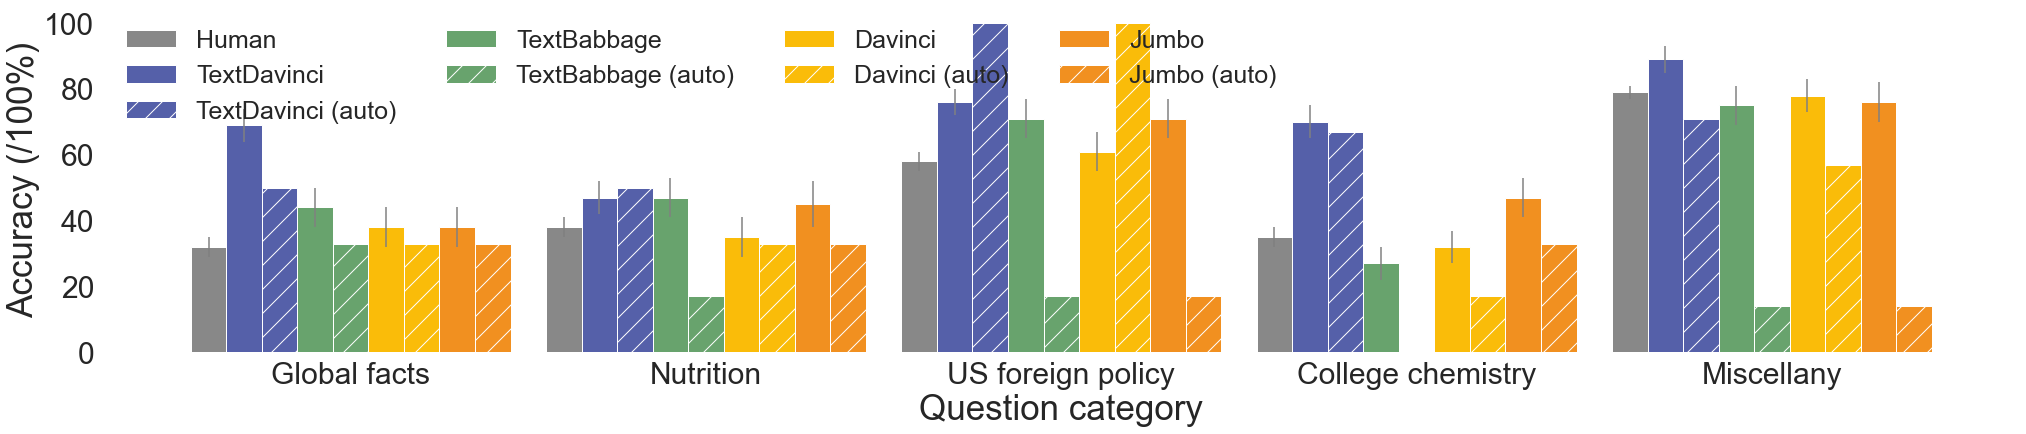

In [92]:
"""
Plot per-question accuracy broken down by category
"""
barWidth = 0.10
num_categories = len(categories)
num_models = len(models)

model_colors = [
    '#888888',  # Human
    
    '#5560A9',  # InstructDavinci
    '#5560A9',
    
    '#68A36D',  # InstructBabbage
    '#68A36D',
    
    '#FABC09',  # Davinci
    '#FABC09',
    
    '#F19020',  # Jumbo
    '#F19020',
]

positions = []
default = np.arange(len(categories))
positions.append(default)
for i in range(num_models):
    p = []
    for x in default:
        p.append(x + barWidth * (i + 1))
    positions.append(p)

fig, ax = plt.subplots()
plt.rcParams["figure.figsize"] = (28,6)

for i, model in enumerate(models):
    if i % 2 == 1 or i == 0:
        rect = ax.bar(
            positions[i], 
            model_to_mean[model], 
            barWidth, 
            label=model,
            color=model_colors[i]
        )
        
        if model in model_to_sem:
            # add error bars
            plt.errorbar(positions[i], model_to_mean[model], yerr=model_to_sem[model], color="gray", linestyle='')
    else:
        rect = ax.bar(
            positions[i], 
            model_to_mean[model], 
            barWidth, 
            label=model,
            color=model_colors[i],
            hatch='/'
        )
# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Question category', fontsize=35)
ax.set_ylabel('Accuracy (/100%)', fontsize=35)
ax.set_xticks([r + barWidth * (num_models / 2) - (barWidth / 2) for r in range(len(labels))], labels)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

leg = ax.legend(ncol=4, columnspacing=2, loc='upper left', frameon=False, prop={'size': 25})

plt.subplots_adjust(top=1, bottom=0.2, left=0.05, right=1)

<a id='crossword_puzzles'></a>

## 3. Crossword puzzles

In [93]:
data = read_data('crossword')

In [97]:
df_accuracy = data['accuracies']
df_accuracy.head()

,session_id,worker_id,model,prompt,prompt_dataset,letter_accuracy,clue_accuracy
0,61_657acabbc3d6aedeba544da278117752_text-davinci,657acabbc3d6aedeba544da278117752,TextDavinci,61,NYT-1,0.378378,0.230769
1,173_4f253ee03ca7132e6d47cc1ebd671ce8_ai2-jumbo,4f253ee03ca7132e6d47cc1ebd671ce8,Jumbo,173,NYT-2,0.243243,0.192308
2,61_8cd5c241d19bd39c83557e684c5c0ce4_text-babbage,8cd5c241d19bd39c83557e684c5c0ce4,TextBabbage,61,NYT-1,0.297297,0.179487
3,61_a9c7faeb33dba785fed1c36cb0cb900b_text-davinci,a9c7faeb33dba785fed1c36cb0cb900b,TextDavinci,61,NYT-1,0.389189,0.307692
4,61_856818cc4b4e6e71b3dd2f4231e4faa6_text-babbage,856818cc4b4e6e71b3dd2f4231e4faa6,TextBabbage,61,NYT-1,0.064865,0.025641


In [96]:
metrics = ['letter_accuracy', 'clue_accuracy']
scales = [100, 100]
print_latex(new_default_models, metrics, scales, df_accuracy, latex=False)

               letter_accuracy     clue_accuracy       
TextDavinci    63 ± 2.9            53 ± 3.4            
TextBabbage    47 ± 3.3            38 ± 3.5            
Davinci        55 ± 3.5            46 ± 3.6            
Jumbo          56 ± 2.8            45 ± 3.1            


In [99]:
df_survey = data['survey_responses']
df_survey = df_survey.rename(columns={
    'joy': 'enjoyment',
})
df_survey.head()

,session_id,worker_id,model,prompt,prompt_dataset,fluency,helpfulness,ease,enjoyment,helpfulness_freetext,change_freetext,adjectives
0,151_57c10c96802f13f8acb3ed38f9f5c02c_ai2-jumbo,57c10c96802f13f8acb3ed38f9f5c02c,Jumbo,151,ELECT,3,2,3,1,I often had to ask the same question more than...,I just kept trying to word my questions in a w...,"confusing, inefficient"
1,151_01f7abec1f2c69d2aa5270b8e4f151ca_text-babbage,01f7abec1f2c69d2aa5270b8e4f151ca,TextBabbage,151,ELECT,3,1,5,2,The AI seems to be looking up and pasting in a...,I tried to adapt how I was asking questions to...,"frustrating, inept, unproductive"
2,151_eb82ff0f084d0ac8ef06249ef287ad3f_ai2-jumbo,eb82ff0f084d0ac8ef06249ef287ad3f,Jumbo,151,ELECT,1,1,1,1,They kept repeating gibberish for their respon...,"Sometimes I'd include quotations, sometimes I'...","Confusing, difficult, illogical"
3,151_d202202ed22b7466c6586cf51beba7b6_text-babbage,d202202ed22b7466c6586cf51beba7b6,TextBabbage,151,ELECT,2,1,5,3,The answers it gave felt like the type of thin...,I tried to be more simple and specific with my...,"Useless, focused on singular words."
4,151_ade83d319adf6296b57cfe1d004e1cf7_text-babbage,ade83d319adf6296b57cfe1d004e1cf7,TextBabbage,151,ELECT,2,2,2,2,it helped with only a couple clues I was prett...,you have to be kind of ambiguous because it is...,it was a little rude to be honest lol


In [101]:
metrics = ['fluency', 'helpfulness', 'ease', 'enjoyment']
scales = [1, 1, 1, 1]
print_latex(new_default_models, metrics, scales, df_survey, latex=False)

               fluency             helpfulness         ease                enjoyment           
TextDavinci    3.65 ± 0.10         3.14 ± 0.12         4.35 ± 0.10         2.91 ± 0.20         
TextBabbage    3.14 ± 0.13         2.27 ± 0.14         3.78 ± 0.15         2.19 ± 0.22         
Davinci        2.26 ± 0.11         1.92 ± 0.10         3.32 ± 0.14         1.92 ± 0.17         
Jumbo          2.30 ± 0.10         2.20 ± 0.10         3.08 ± 0.15         1.66 ± 0.18         


In [103]:
categories = ['NYT-1', 'NYT-2', 'ELECT', 'LOVE', 'SIT']
model_to_mean = dict()
model_to_sem = dict()

In [105]:
for model in new_default_models:
    mean = []
    sem = []
    for category in categories:
        df_model = df_survey.query(f'model == "{model}" & prompt_dataset == "{category}"')['helpfulness']
        mean.append(round(df_model.mean(), 2))
        sem.append(round(df_model.sem(), 2))
    model_to_mean[model] = mean
    model_to_sem[model] = sem
model_to_mean, model_to_sem

({'TextDavinci': [3.13, 3.36, 2.8, 2.89, 3.56],
  'TextBabbage': [1.95, 2.21, 2.43, 2.15, 2.83],
  'Davinci': [2.0, 2.27, 1.87, 1.75, 1.72],
  'Jumbo': [2.05, 2.2, 2.53, 2.17, 2.13]},
 {'TextDavinci': [0.31, 0.23, 0.28, 0.21, 0.26],
  'TextBabbage': [0.25, 0.35, 0.34, 0.3, 0.37],
  'Davinci': [0.18, 0.27, 0.31, 0.22, 0.16],
  'Jumbo': [0.23, 0.17, 0.26, 0.24, 0.22]})

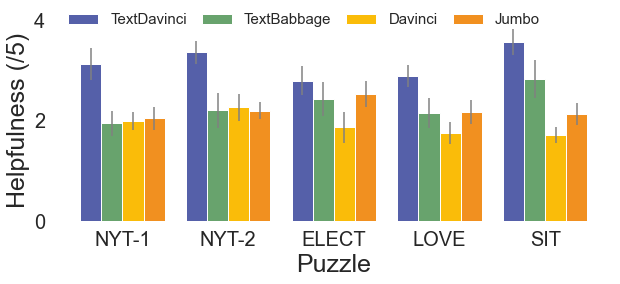

In [110]:
generate_barplot(
    model_to_mean, model_to_sem,
    categories, new_default_models, default_model_colors,
    'Puzzle', 'Helpfulness (/5)', 'crossword-puzzle-helpfulness.pdf'
)

<a id='text_summarization'></a>

## 4. Text summarization

In [111]:
data = read_data('summarization')

In [114]:
df_summary = data['event_blocks']
df_summary = df_summary.rename(columns={
    'distance': 'edit_distance',
})
df_summary = df_summary.astype({
    'original_consistency': 'int',
    'original_relevance': 'int',
    'original_coherency': 'int',
    'edited_consistency': 'int',
    'edited_relevance': 'int',
    'edited_coherency': 'int',
})
df_summary.head()

,name,session_id,worker_id,order_id,model,prompt,elapsed_time,document,original_summary,original_normalized_summary,...,edited_consistency,edited_coherency,edited_relevance,edit_distance,original_consistency_third_party,original_relevance_third_party,original_coherency_third_party,edited_consistency_third_party,edited_relevance_third_party,edited_coherency_third_party
0,summary-00,12195ed75008463084d1b299d6c39106,A1VZSFHTU51JP0,0,TextBabbage,13,1.99,Canada presents a chance for Lewis Hamilton to...,Lewis Hamilton will start from pole and win th...,lewis hamilton will start from pole and win th...,...,1,1,1,11,NaN,NaN,NaN,NaN,NaN,NaN
1,summary-01,12195ed75008463084d1b299d6c39106,A1VZSFHTU51JP0,1,TextBabbage,13,1.78,The eggs were produced by the mating pair Mont...,"The eggs of a pair of Monty and Glesni, which ...",the eggs of a pair of monty and glesni which h...,...,1,1,1,9,NaN,NaN,NaN,NaN,NaN,NaN
2,summary-02,12195ed75008463084d1b299d6c39106,A1VZSFHTU51JP0,2,TextBabbage,13,0.26,Hylton joined Luton on a two-year deal in May ...,Hylton has joined Luton on a two-year contract...,hylton has joined luton on a twoyear contract ...,...,1,1,1,0,1.00,4.67,5.00,1.0,4.67,5.00
3,summary-03,12195ed75008463084d1b299d6c39106,A1VZSFHTU51JP0,3,TextBabbage,13,2.87,"World number nine O'Sullivan, 40, rallied from...",O'Sullivan won 6-4 against Norwegian world num...,osullivan won 64 against norwegian world numbe...,...,1,1,1,29,0.33,3.33,3.67,1.0,4.67,4.33
4,summary-04,12195ed75008463084d1b299d6c39106,A1VZSFHTU51JP0,4,TextBabbage,13,8.27,A 43-year-old man was found at a house in Shir...,A 43-year-old man was found at a house in Shir...,a 43yearold man was found at a house in shirle...,...,1,1,1,30,NaN,NaN,NaN,NaN,NaN,NaN


In [116]:
metrics = ['original_length', 'edited_length', 'edit_distance']
scales = [1, 1, 1]
print_latex(new_default_models, metrics, scales, df_summary, latex=False)

               original_length     edited_length       edit_distance       
TextDavinci    17.70 ± 0.47        25.08 ± 0.89        12.38 ± 0.89        
TextBabbage    20.11 ± 0.43        32.61 ± 0.85        16.34 ± 0.91        
Davinci        16.96 ± 0.38        25.05 ± 0.89        14.19 ± 0.89        
Jumbo          14.75 ± 0.34        25.33 ± 0.82        15.12 ± 0.83        


In [118]:
df_survey = data['survey_responses']
df_survey = df_survey.rename(columns={
    'edit': 'revision',
})
df_survey.head()

,session_id,worker_id,model,prompt,improvement,revision,helpfulness,adjectives
0,e8413d582ebe4eabbe506c41941b6836,AKQAI78JTXXC9,TextDavinci,0,1,2,4,reliable
1,c7dd721f7b114ab4a88a3a85c58e15cb,A37EV8RZ82WT8E,TextBabbage,1,5,2,5,"Smart, useful, quick"
2,ea565af9f33c409585734547d794b108,AKQAI78JTXXC9,Jumbo,2,1,3,3,somewhat unreliable
3,e57d8c09caa4414e859df62181980cb1,AKQAI78JTXXC9,Davinci,3,1,3,4,somewhat helpful
4,8d04dfc1924147e19c166bd3d7249a3d,A37EV8RZ82WT8E,TextDavinci,4,4,3,5,"Intelligent, useful, creative"


In [119]:
metrics = ['revision', 'helpfulness', 'improvement']
scales = [1, 1, 1]
print_latex(new_default_models, metrics, scales, df_survey, latex=False)

               revision            helpfulness         improvement         
TextDavinci    3.00 ± 0.19         4.20 ± 0.19         2.60 ± 0.29         
TextBabbage    3.40 ± 0.17         3.40 ± 0.28         2.15 ± 0.21         
Davinci        3.25 ± 0.20         3.80 ± 0.22         2.10 ± 0.20         
Jumbo          3.30 ± 0.21         3.30 ± 0.25         2.40 ± 0.28         


In [120]:
metrics = [
    'original_consistency_third_party', 
    'original_relevance_third_party', 
    'original_coherency_third_party'
]
scales = [100, 1, 1]
print_latex(new_default_models, metrics, scales, df_summary, latex=False)

               original_consistency_third_partyoriginal_relevance_third_partyoriginal_coherency_third_party
TextDavinci    65 ± 3.9            4.07 ± 0.08         4.70 ± 0.04         
TextBabbage    89 ± 2.6            4.15 ± 0.06         4.51 ± 0.06         
Davinci        57 ± 4.1            3.70 ± 0.09         4.53 ± 0.05         
Jumbo          56 ± 3.9            3.80 ± 0.07         4.60 ± 0.04         


<a id='metaphor_generation'></a>

## 5. Metaphor generation

In [140]:
data = read_data('metaphor')

In [148]:
df_sentences = data['event_blocks']
df_sentences = df_sentences.rename(columns={
    'elapsed_time': 'time',
    'num_queries': 'queries',
    'edit_model_final_token': 'edit_distance',
})
df_sentences.head()

,session_id,worker_id,order_id,norm_order_id,model,prompt,time,queries,num_events,acceptance,model_completion,final_sentence,edit_distance,edit_model_final_char,apt,specific,imageable,overall
0,6974535619244ad4a883e684caa10e7d,A2OVOVZBJYUO,0,0.00,TextBabbage,progress,0.90,1,25,100.0,We'll keep dancing until we reach the top.,We'll keep dancing until we reach the top.,0,0,0.0,0.5,0.0,NaN
1,6974535619244ad4a883e684caa10e7d,A2OVOVZBJYUO,1,0.07,TextBabbage,progress,0.74,0,128,NaN,NaN,We will fall into a rhythm and find our way.,10,44,0.5,1.0,0.5,0.666667
2,6974535619244ad4a883e684caa10e7d,A2OVOVZBJYUO,2,0.14,TextBabbage,progress,0.71,1,32,100.0,We'll move through the obstacles together.,We'll move through the obstacles together.,0,0,NaN,NaN,NaN,NaN
3,6974535619244ad4a883e684caa10e7d,A2OVOVZBJYUO,3,0.21,TextBabbage,progress,0.42,0,81,NaN,NaN,There is more than one way to move forward.,9,43,0.5,0.5,0.5,0.500000
4,6974535619244ad4a883e684caa10e7d,A2OVOVZBJYUO,4,0.29,TextBabbage,progress,0.12,1,9,100.0,We'll take it one step at a time.,We'll take it one step at a time.,0,0,NaN,NaN,NaN,NaN


In [149]:
metrics = ['time', 'queries', 'acceptance']
scales = [1, 1, 1, 1]
print_latex(new_default_models, metrics, scales, df_sentences, latex=False)

               time                queries             acceptance          
TextDavinci    0.74 ± 0.07         0.92 ± 0.07         50.79 ± 4.39        
TextBabbage    0.73 ± 0.04         0.97 ± 0.09         55.68 ± 3.62        
Davinci        0.60 ± 0.05         0.77 ± 0.06         71.48 ± 4.08        
Jumbo          0.75 ± 0.06         1.03 ± 0.11         68.29 ± 4.28        


In [151]:
metrics = ['edit_distance']
scales = [1]
print_latex(new_default_models, metrics, scales, df_sentences.query('acceptance > 0'), latex=False)

               edit_distance       
TextDavinci    4.79 ± 0.52         
TextBabbage    6.43 ± 0.73         
Davinci        4.83 ± 0.60         
Jumbo          5.59 ± 0.54         


In [132]:
df_survey = data['survey_responses']
df_survey.head()

,session_id,worker_id,model,prompt,fluency,helpfulness,ease,enjoyment,satisfaction,ownership,reuse
0,6974535619244ad4a883e684caa10e7d,A2OVOVZBJYUO,TextBabbage,progress,4,5,3,3,4,3,4
1,a855d109d86a4d9aa17da60ae39755ed,A22VGT2F28LTWC,Davinci,life,4,5,4,4,4,3,5
2,19da2035279f4beb96d654315597b5ea,A1198W1SPF1R4,Davinci,life,4,5,5,5,4,5,5
3,6ce746e3539341158345ad78fdbba2b5,A2WGW5Y3ZFBDEC,Jumbo,progress,3,4,4,2,4,5,3
4,5aedf26f952b457aa9941dd698b9460a,A2YTQDLACTLIBA,TextBabbage,theory,4,5,5,5,5,5,5


In [134]:
metrics = ['helpfulness', 'satisfaction', 'ease', 'reuse']
scales = [1, 1, 1, 1, 1]
print_latex(new_default_models, metrics, scales, df_survey, latex=False)

               helpfulness         satisfaction        ease                reuse               
TextDavinci    4.21 ± 0.18         4.42 ± 0.14         3.68 ± 0.22         4.42 ± 0.18         
TextBabbage    3.64 ± 0.21         4.14 ± 0.20         3.82 ± 0.23         4.39 ± 0.17         
Davinci        4.17 ± 0.23         4.33 ± 0.20         3.94 ± 0.25         4.61 ± 0.14         
Jumbo          4.13 ± 0.24         4.40 ± 0.13         3.87 ± 0.24         4.47 ± 0.19         


In [154]:
metrics = ['apt', 'specific', 'imageable', 'overall']
scales = [100, 100, 100, 100]
print_latex(new_default_models, metrics, scales, df_sentences.query('acceptance > 0'), latex=False)

               apt                 specific            imageable           overall             
TextDavinci    75 ± 4.0            78 ± 4.6            75 ± 4.6            78 ± 3.4            
TextBabbage    75 ± 4.0            79 ± 3.7            70 ± 5.0            78 ± 3.0            
Davinci        90 ± 3.3            90 ± 3.3            83 ± 5.3            88 ± 3.0            
Jumbo          77 ± 5.5            83 ± 5.3            72 ± 5.7            84 ± 3.9            
